## Imports

In [1]:
import os
import sys
sys.path.append("../")
import csv
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import settings
from prediction_dataset import PredictionDataset
from process_sentinel3 import OLCIdataGenerator

from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pickle
from math import isnan

from utils import parse_ficocianina_xls

## Methods

In [2]:
def metrics(gt, pred, labels=["No Bloom", "Bloom"]):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred, pos_label=labels[1]), 2)
    metrics["recall"] = round(recall_score(gt, pred, pos_label=labels[1]), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred, labels=labels)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

In [3]:
processed_data_path = settings.processed_data_path

DATE_FORMAT = '%Y-%m-%d'

ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation_pdir.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
ta_ose_path = os.path.join(settings.final_data_path, "agua_open_data(1).csv")
s3_brrs_path = os.path.join(settings.final_data_path, "s3_brrs.json")

raw_cyano_gt_path = os.path.join(settings.final_data_path, "MUESTREOS_SEMANALES_2016-2017-2018-2019-2020.xls")

bloom_thresholds = {
                    "MALLORQUINA":7000,
                    "ARROYO SAUCE": 7000,
                    "SAUCE NORTE": 7000,
                    "SAUCE SUR": 7000,
                    "CISNES": 7000,
                    "POTRERO": 7000,
                    "TA":3000
                   }

sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

In [4]:
dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, 
                            ndci_data_path, algae_gt_path, s3_brrs_path, bloom_thresholds=bloom_thresholds)

../prediction_dataset.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data_df["label"] = days_before_bloom_col


In [5]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.0,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
809,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
810,2023-02-25,SAUCE NORTE,1412.5,3.40,No Bloom
811,2023-02-25,SAUCE SUR,2002.5,4.70,No Bloom
812,2023-02-25,CISNES,1669.0,3.60,No Bloom


## Blooming detection with MPH

In [5]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

predicted_dates = {"SAUCE NORTE": [],
                    "SAUCE SUR": [],
                    "TA": []}

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.replace(hour=0, minute=0, second=0, microsecond=0)]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
        
        location_name = row["location"]
        location_coords = sampling_points_coords[location_name]
        
        mph_bloom_pred = olci_data.get_mph_bloom_in_locations([location_coords])

        y_pred[row["location"]].append("Bloom" if mph_bloom_pred == True else "No Bloom")
        y_gt[row["location"]].append(row["label"])
        predicted_dates[row["location"]].append(olci_data.date)

SAUCE NORTE
Accuracy: 0.86
Precision: 0.65
Recall: 1.0
FPR: 0.0
FNR: 0.19


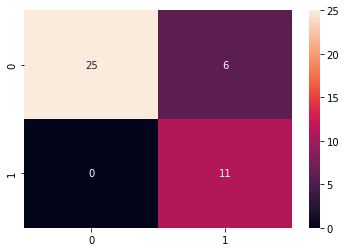

SAUCE SUR
Accuracy: 0.86
Precision: 0.65
Recall: 1.0
FPR: 0.0
FNR: 0.19


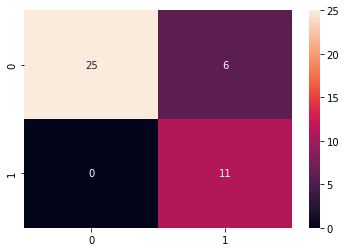

TA
Accuracy: 0.86
Precision: 0.77
Recall: 1.0
FPR: 0.0
FNR: 0.26


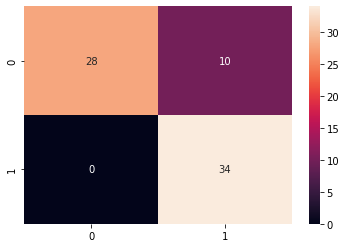

In [6]:
for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

## Bloom detection using MPH + rain, temperature and wind

In [81]:
sample_date = datetime(2020, 12, 1)
dataset.get_historic_data(sample_date, 5)[["date", "wind", "temperature", "precipitation"]]

,date,wind,temperature,precipitation
0,2020-12-01,4.5,17.0,0.250000
1,2020-11-30,14.5,17.0,1.121622
2,2020-11-29,13.5,21.0,1.516892
3,2020-11-28,12.0,21.5,5.449324
4,2020-11-27,9.0,18.0,0.000000


### Measure correlations

In [13]:
infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
correlations = infinite_defaultdict() 

accumulation_methods = ["sum", "min", "max", "mean"]
# try to find correlations accumulating data from in different amounts of days before the dates with GT
for days_before in [100, 200, 365]:
    accumulation_data = []
    for index, row in dataset.algae_gt.iterrows():
        if row["location"] not in ["SAUCE NORTE", "SAUCE SUR", "TA"]:
            continue

        row_date = datetime(row["date"].year, row["date"].month, row["date"].day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, days_before)

        if len(historic_data) == 0: continue

        item = {"date": row["date"], "label": row["label"]}
        for m in accumulation_methods:
            item["precipitation_" + m] = getattr(historic_data["precipitation"], m)()
            item["temperature_" + m] = getattr(historic_data["temperature"], m)()
            item["wind_" + m] = getattr(historic_data["wind"], m)()
        accumulation_data.append(item)
    
    accumulation_df = pd.DataFrame(accumulation_data)
    accumulation_df = accumulation_df[accumulation_df["date"] >= datetime(2018, 11, 1)]
    accumulation_df["numeric label"] = accumulation_df["label"].replace("No Bloom", 0)
    accumulation_df["numeric label"] = accumulation_df["numeric label"].replace("Bloom", 1)
    
    print(f"{days_before} days accumulation")
    for d in ["precipitation", "temperature", "wind"]:
        for m in accumulation_methods:
            accumulation_dataname = f"{d}_{m}"
            accumulation_correlation = accumulation_df['numeric label'].corr(accumulation_df[accumulation_dataname])
            print(f"{accumulation_dataname} ----> {accumulation_correlation}")
            correlations[d][days_before][m] = accumulation_correlation
    print("////////////")

100 days accumulation
precipitation_sum ----> -0.2468120834574421
precipitation_min ----> nan
precipitation_max ----> -0.19126575939297596
precipitation_mean ----> -0.24681208345744188
temperature_sum ----> 0.07661194988164208
temperature_min ----> 0.11240248824146057
temperature_max ----> 0.2770764908771064
temperature_mean ----> 0.19318204309331816
wind_sum ----> 0.028173633463416017
wind_min ----> -0.3166211122934426
wind_max ----> 0.5698828019612803
wind_mean ----> 0.13200855441718284
////////////
200 days accumulation
precipitation_sum ----> -0.4592479228988771
precipitation_min ----> nan
precipitation_max ----> -0.38245691829333645
precipitation_mean ----> -0.45924792289887717
temperature_sum ----> 0.14074346493951556
temperature_min ----> 0.4880807463089004
temperature_max ----> 0.2741153593254792
temperature_mean ----> 0.4548818888456519
wind_sum ----> -0.01532936634496666
wind_min ----> 0.01683227208135036
wind_max ----> 0.39905050281636045
wind_mean ----> -0.00091960053844476

## Prediction with MPH indexes

In [7]:
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

X = []
y = []
dates_list = []

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.replace(hour=0, 
                                                                                      minute=0, 
                                                                                      second=0, 
                                                                                      microsecond=0)]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in ["SAUCE NORTE", "SAUCE SUR", "TA"]):
            continue
            
        dates_list.append(row["date"])
            
        y.append(row["label"])
        
        location_coords = sampling_points_coords[row["location"]]
        
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        #get a 3x3 grid centered on the sampling location
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()
        
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].min()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].min()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].min()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].min()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].min()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].min()
#         lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].min()

#         NDVI = olci_data.mph.NDVI[i, j]
#         BAIR = olci_data.mph.BAIR[i, j]
#         SICF = olci_data.mph.SICF[i, j]
#         SIPF = olci_data.mph.SIPF[i, j]
#         MPH0 = olci_data.mph.MPH0[i, j]
#         MPH1 = olci_data.mph.MPH1[i, j]
#         lambda_max1 = olci_data.mph.lambda_max1[i, j]
        
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].max()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].max()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].max()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].max()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].max()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].max()
#         lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()
        
        X.append([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
X = np.array(X)
y = np.array(y)

In [8]:
dates_list

[Timestamp('2017-01-11 00:00:00'),
 Timestamp('2017-01-11 00:00:00'),
 Timestamp('2017-01-18 00:00:00'),
 Timestamp('2017-01-18 00:00:00'),
 Timestamp('2018-01-03 00:00:00'),
 Timestamp('2018-01-03 00:00:00'),
 Timestamp('2018-01-11 00:00:00'),
 Timestamp('2018-01-11 00:00:00'),
 Timestamp('2018-02-15 00:00:00'),
 Timestamp('2018-02-15 00:00:00'),
 Timestamp('2018-03-07 00:00:00'),
 Timestamp('2018-03-07 00:00:00'),
 Timestamp('2018-04-18 00:00:00'),
 Timestamp('2018-04-18 00:00:00'),
 Timestamp('2018-11-20 00:00:00'),
 Timestamp('2018-11-20 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-03-07 00:00:00'),
 Timestamp('2019-03-07 00:00:00'),
 Timestamp('2019-11-

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.93
Precision: 0.87
Recall: 0.95
FPR: 0.05
FNR: 0.08


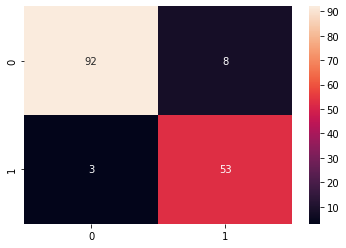

LogisticRegression()
Accuracy: 0.6
Precision: 0.11
Recall: 0.02
FPR: 0.98
FNR: 0.08


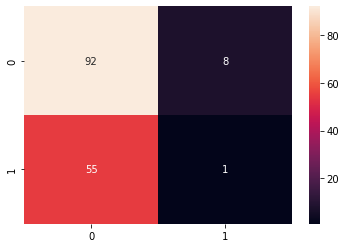

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.94
Precision: 0.88
Recall: 0.95
FPR: 0.05
FNR: 0.07


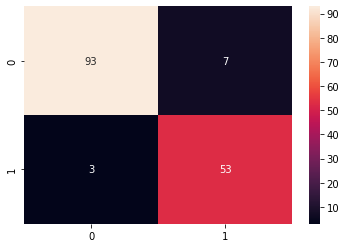

GaussianNB()
Accuracy: 0.91
Precision: 0.85
Recall: 0.91
FPR: 0.09
FNR: 0.09


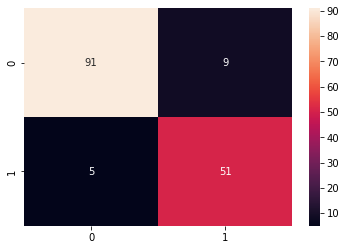

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.91
Precision: 0.88
Recall: 0.88
FPR: 0.12
FNR: 0.07


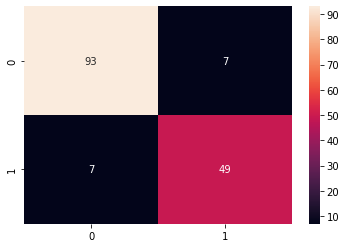

KNeighborsClassifier()
Accuracy: 0.81
Precision: 0.73
Recall: 0.77
FPR: 0.23
FNR: 0.16


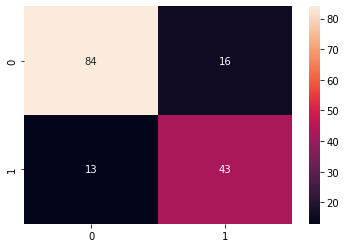

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.94
Precision: 0.9
Recall: 0.95
FPR: 0.05
FNR: 0.06


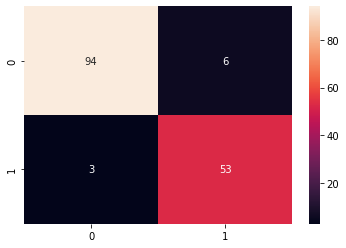

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.94
Precision: 0.91
Recall: 0.91
FPR: 0.09
FNR: 0.05


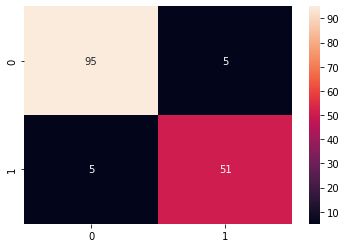

LGBMClassifier()
Accuracy: 0.93
Precision: 0.88
Recall: 0.93
FPR: 0.07
FNR: 0.07


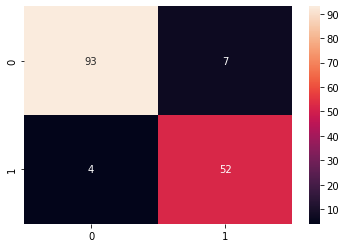

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.94
Precision: 0.9
Recall: 0.93
FPR: 0.07
FNR: 0.06


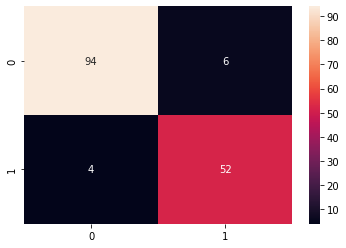

In [9]:
clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        LogisticRegression(),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        KNeighborsClassifier(n_neighbors=5),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        
        
#cv = StratifiedKFold(n_splits=2)
cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    #     m = metrics(y_test, y_pred)
    #     print("Accuracy:", m["accuracy"])
    #     print("Precision:", m["precision"])
    #     print("Recall:", m["recall"])
    #     print("FPR:", m["false positive rate"])
    #     print("FNR:", m["false negative rate"])
    #     sns.heatmap(m["confusion matrix"], annot=True)
    #     plt.show()

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

[Text(186.0, 475.65000000000003, 'SIPF <= 0.0\ngini = 0.46\nsamples = 156\nvalue = [56, 100]\nclass = Bloom'),
 Text(93.0, 339.75, 'gini = 0.0\nsamples = 92\nvalue = [0, 92]\nclass = Bloom'),
 Text(279.0, 339.75, 'MPH0 <= 0.005\ngini = 0.219\nsamples = 64\nvalue = [56, 8]\nclass = No Bloom'),
 Text(186.0, 203.85000000000002, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Bloom'),
 Text(372.0, 203.85000000000002, 'SICF <= -0.007\ngini = 0.175\nsamples = 62\nvalue = [56, 6]\nclass = No Bloom'),
 Text(279.0, 67.94999999999999, 'gini = 0.0\nsamples = 34\nvalue = [34, 0]\nclass = No Bloom'),
 Text(465.0, 67.94999999999999, 'gini = 0.337\nsamples = 28\nvalue = [22, 6]\nclass = No Bloom')]

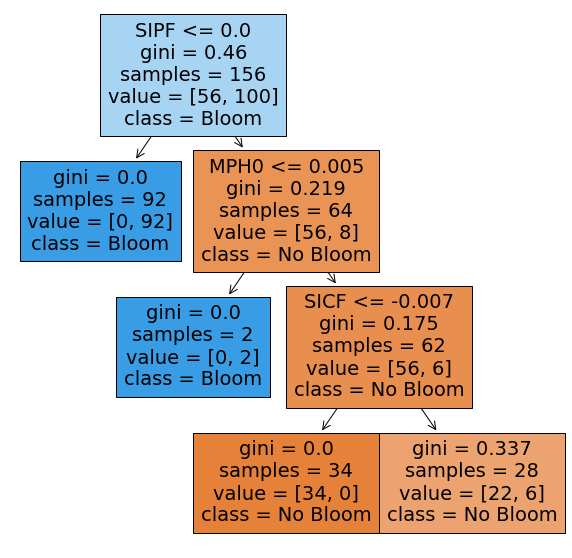

In [10]:
plt.figure(figsize=(10,10))
clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf.fit(X, y)
tree.plot_tree(clf, 
               feature_names=["NDVI", "BAIR", "SICF", "SIPF", "MPH0", "MPH1", "lambda_max1"],  
               class_names=["No Bloom", "Bloom"],
               filled=True)

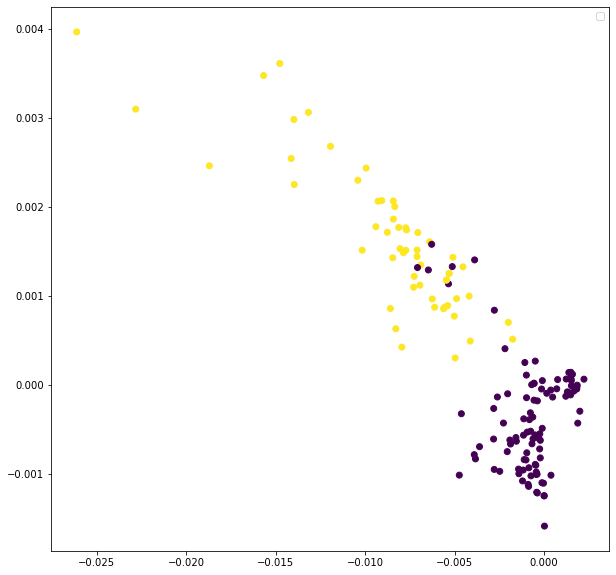

In [12]:
y_binary = np.zeros(y.shape)
for i in range(y_binary.shape[0]):
    if y[i] == "No Bloom":
        y_binary[i] = 0
    else:
        y_binary[i] = 1

plt.figure(figsize=(10,10))
plt.scatter(X[:, 2], X[:, 3], c=y_binary)
plt.show()

### Extend features using climate data

In [26]:
climate_features = np.zeros((len(dates_list), 3))
# climate_features_meta = {"precipitation": {"accumulation_days": 365, "accumulation_type": "sum"},
#                          "temperature": {"accumulation_days": 9, "accumulation_type": "max"},
#                          "wind": {"accumulation_days": 9, "accumulation_type": "max"}}
# climate_features_meta = {"precipitation": {"accumulation_days": 200, "accumulation_type": "sum"}}
climate_features_meta = {"precipitation": {"accumulation_days": 200, "accumulation_type": "sum"},
                         "temperature": {"accumulation_days": 200, "accumulation_type": "mean"}
                        }
for idx, key_value in enumerate(climate_features_meta.items()):
    climate_feature_name = key_value[0]
    feature_metadata = key_value[1]
    feature_accumulated_data = []
    for date_idx, d in enumerate(dates_list):
        row_date = datetime(d.year, d.month, d.day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, feature_metadata["accumulation_days"])

        if len(historic_data) == 0:
            print(f"{d} has no historic data")
            continue

        climate_feature_value = getattr(historic_data[climate_feature_name], feature_metadata["accumulation_type"])()
        if isnan(climate_feature_value):
            print(historic_data[["date", climate_feature_name]])
            climate_feature_value = 0
        feature_accumulated_data.append(climate_feature_value)

    climate_features[:, idx] = np.array(feature_accumulated_data)
    
X_extended = np.hstack((X,climate_features))

          date  temperature
0   2017-01-11          NaN
1   2017-01-10          NaN
2   2017-01-09          NaN
3   2017-01-08          NaN
4   2017-01-07          NaN
..         ...          ...
195 2016-06-30          NaN
196 2016-06-29          NaN
197 2016-06-28          NaN
198 2016-06-27          NaN
199 2016-06-26          NaN

[200 rows x 2 columns]
          date  temperature
0   2017-01-11          NaN
1   2017-01-10          NaN
2   2017-01-09          NaN
3   2017-01-08          NaN
4   2017-01-07          NaN
..         ...          ...
195 2016-06-30          NaN
196 2016-06-29          NaN
197 2016-06-28          NaN
198 2016-06-27          NaN
199 2016-06-26          NaN

[200 rows x 2 columns]
          date  temperature
0   2017-01-18          NaN
1   2017-01-17          NaN
2   2017-01-16          NaN
3   2017-01-15          NaN
4   2017-01-14          NaN
..         ...          ...
195 2016-07-07          NaN
196 2016-07-06          NaN
197 2016-07-05          NaN


## Prediction with MPH indexes and climate data

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.93
Precision: 0.88
Recall: 0.93
FPR: 0.07
FNR: 0.07


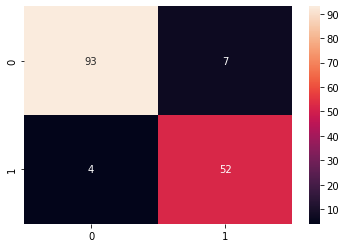

LogisticRegression()
Accuracy: 0.76
Precision: 0.85
Recall: 0.41
FPR: 0.59
FNR: 0.04


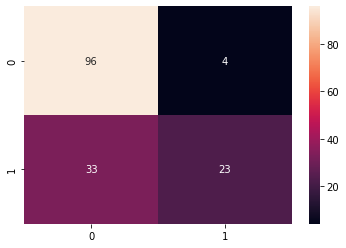

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.94
Precision: 0.9
Recall: 0.95
FPR: 0.05
FNR: 0.06


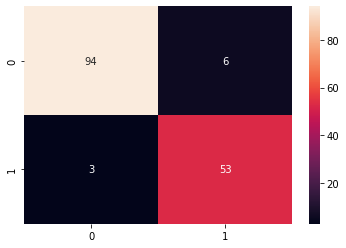

GaussianNB()
Accuracy: 0.89
Precision: 0.88
Recall: 0.8
FPR: 0.2
FNR: 0.06


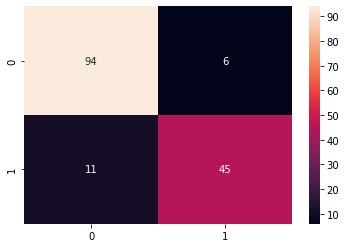

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.9
Precision: 0.87
Recall: 0.84
FPR: 0.16
FNR: 0.07


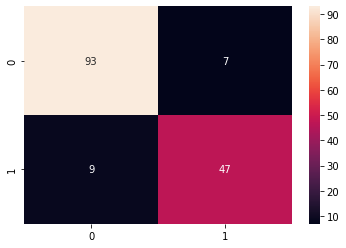

KNeighborsClassifier()
Accuracy: 0.83
Precision: 0.73
Recall: 0.82
FPR: 0.18
FNR: 0.17


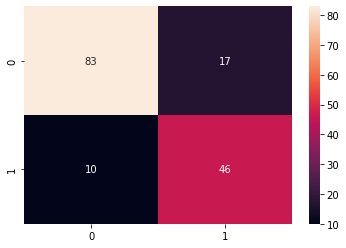

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.95
Precision: 0.9
Recall: 0.96
FPR: 0.04
FNR: 0.06


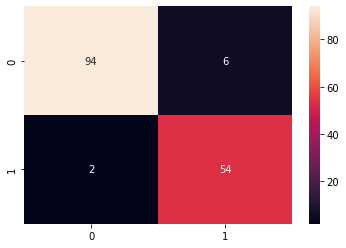

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.96
Precision: 0.93
Recall: 0.95
FPR: 0.05
FNR: 0.04


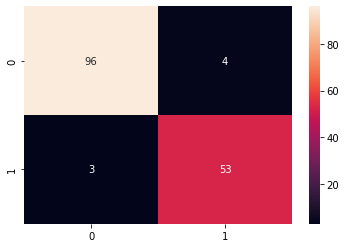

LGBMClassifier()
Accuracy: 0.93
Precision: 0.89
Recall: 0.91
FPR: 0.09
FNR: 0.06


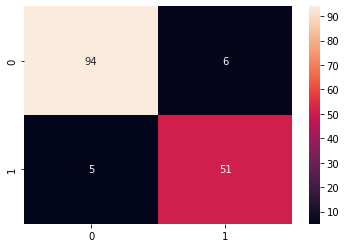

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.94
Precision: 0.9
Recall: 0.95
FPR: 0.05
FNR: 0.06


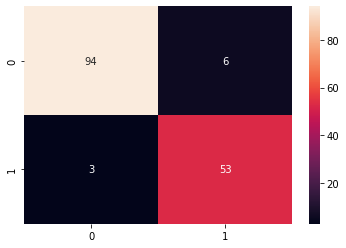

In [27]:
clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        LogisticRegression(),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        KNeighborsClassifier(n_neighbors=5),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        

    
#cv = StratifiedKFold(n_splits=2)
cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X_extended, y):
#     for train_index, test_index in cv.split(X_extended[:-20], y):
        X_train, X_test = X_extended[train_index], X_extended[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    #     m = metrics(y_test, y_pred)
    #     print("Accuracy:", m["accuracy"])
    #     print("Precision:", m["precision"])
    #     print("Recall:", m["recall"])
    #     print("FPR:", m["false positive rate"])
    #     print("FNR:", m["false negative rate"])
    #     sns.heatmap(m["confusion matrix"], annot=True)
    #     plt.show()

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

### Train and save model

In [106]:
filename = 'svc_model_until2020.sav'

In [108]:
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))

model.fit(X[:-20], y[:-20])

print(model.score(X[:-20], y[:-20]))
# save the model to disk
pickle.dump(model, open(filename, 'wb'))

0.9508196721311475


### load the model from disk

In [109]:
svc_model_path = 'svc_model_until2020.sav'
gaussian_nb_model_path = 'gaussianNB_model.sav'

svc_model = pickle.load(open(svc_model_path, 'rb'))
gaussianNB_model = pickle.load(open(gaussian_nb_model_path, 'rb'))

svc_result = svc_model.score(X, y)
gaussianNB_result = gaussianNB_model.score(X, y)
print(svc_result)
print(gaussianNB_result)

0.9295774647887324
0.8873239436619719


## Predictions on unseen data

### Trained model

In [47]:
svc_model_path = 'svc_model.sav'
gaussian_nb_model_path = 'gaussianNB_model.sav'

svc_model = pickle.load(open(svc_model_path, 'rb'))
gaussianNB_model = pickle.load(open(gaussian_nb_model_path, 'rb'))

In [48]:
unseen_dates = ["2022-06-23", "2022-07-30", "2022-08-22", "2022-09-14", 
               "2022-10-31", "2022-11-16", "2022-11-22", "2022-12-05",
               "2022-12-09", "2022-12-14", "2022-12-21", "2022-12-30",
               "2023-01-04", "2023-01-12", "2023-01-19", "2023-01-27",
               "2023-02-02", "2023-02-09", "2023-02-15", "2023-02-25"]

2022-11-16 12:53:49
SAUCE NORTE
SVC model output: No Bloom
GaussianNB model output: No Bloom
MPH output: No Bloom
SAUCE SUR
SVC model output: No Bloom
GaussianNB model output: No Bloom
MPH output: No Bloom
--------------------
2022-12-05 13:01:19
SAUCE NORTE
SVC model output: No Bloom
GaussianNB model output: No Bloom
MPH output: Bloom
SAUCE SUR
SVC model output: No Bloom
GaussianNB model output: No Bloom
MPH output: Bloom
--------------------
2022-12-09 12:57:34
SAUCE NORTE
SVC model output: Bloom
GaussianNB model output: Bloom
MPH output: Bloom
SAUCE SUR
SVC model output: Bloom
GaussianNB model output: Bloom
MPH output: Bloom
--------------------
2022-12-14 13:06:43
SAUCE NORTE
SVC model output: Bloom
GaussianNB model output: Bloom
MPH output: Bloom
SAUCE SUR
SVC model output: No Bloom
GaussianNB model output: No Bloom
MPH output: Bloom
--------------------
2022-12-30 12:51:45
SAUCE NORTE
SVC model output: No Bloom
GaussianNB model output: Bloom
MPH output: No Bloom
SAUCE SUR
SVC mod

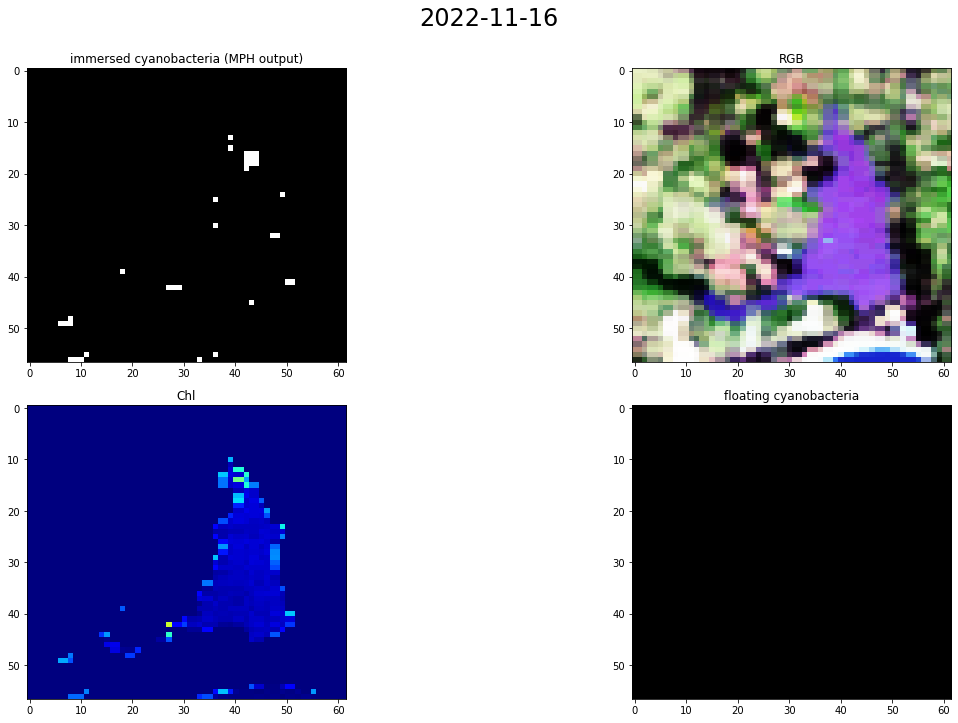

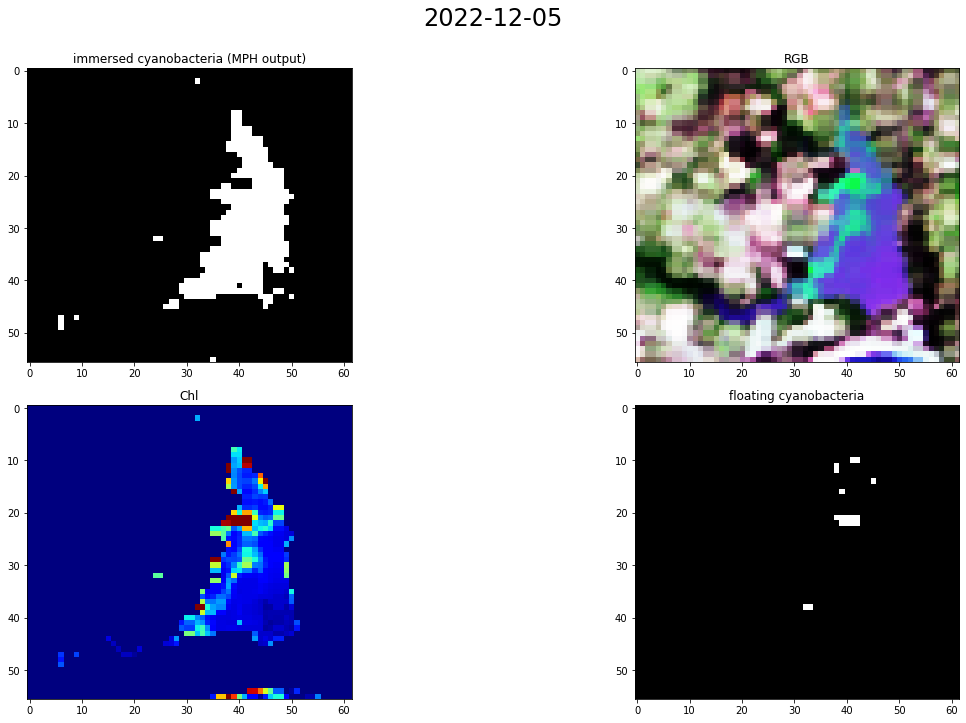

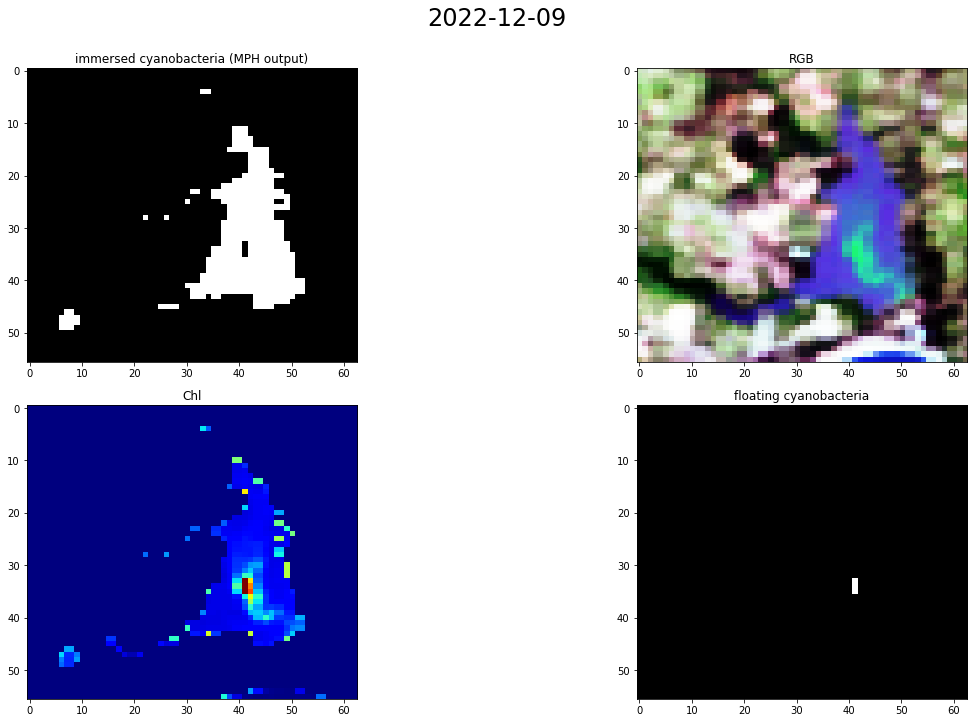

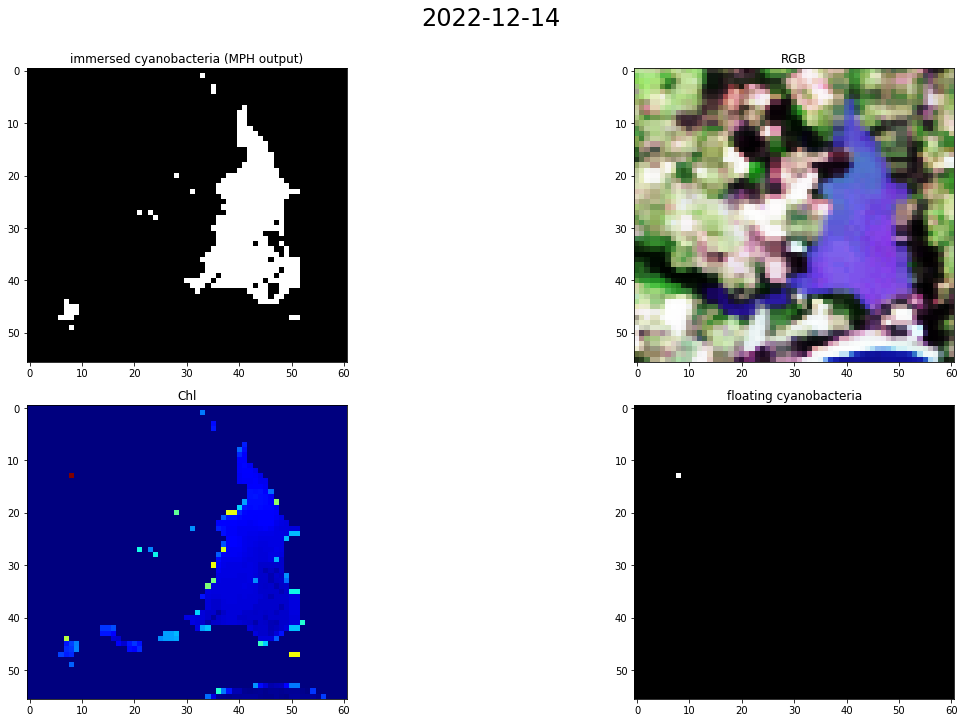

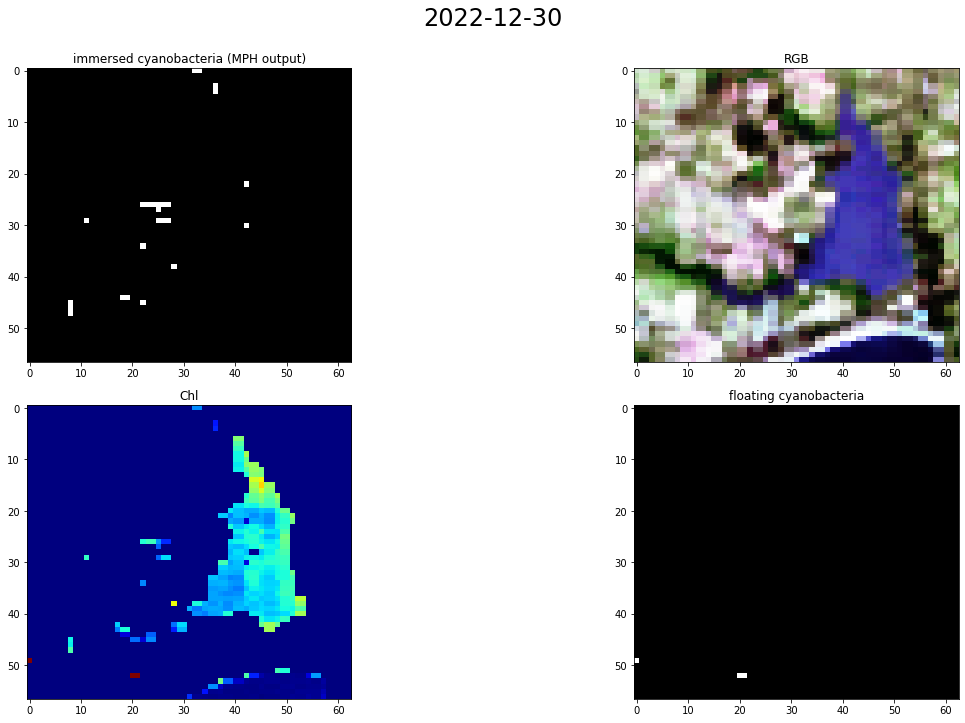

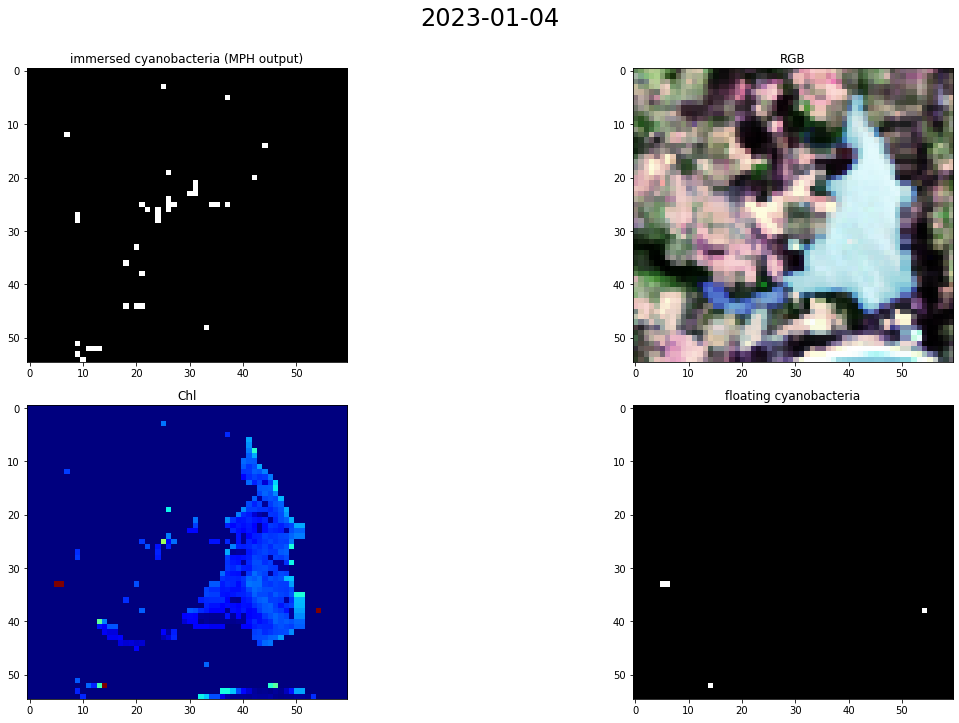

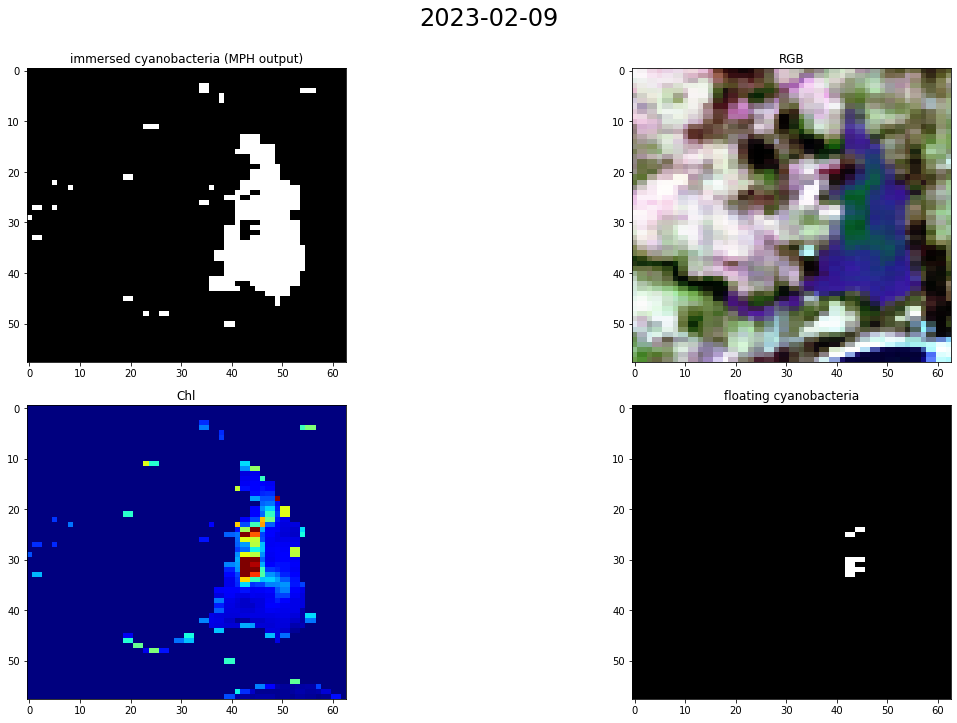

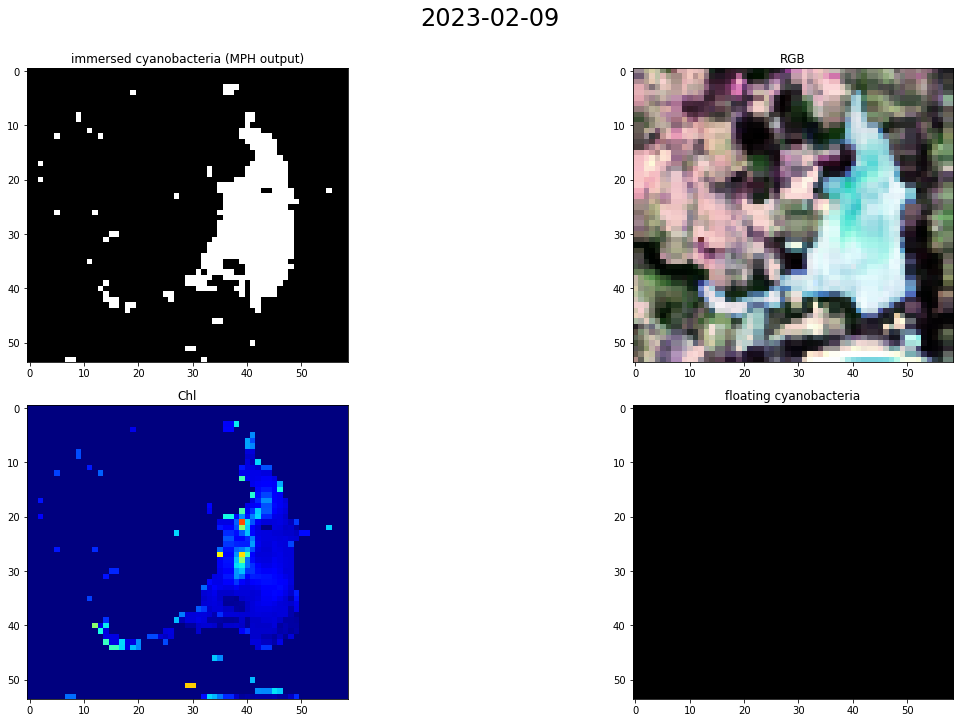

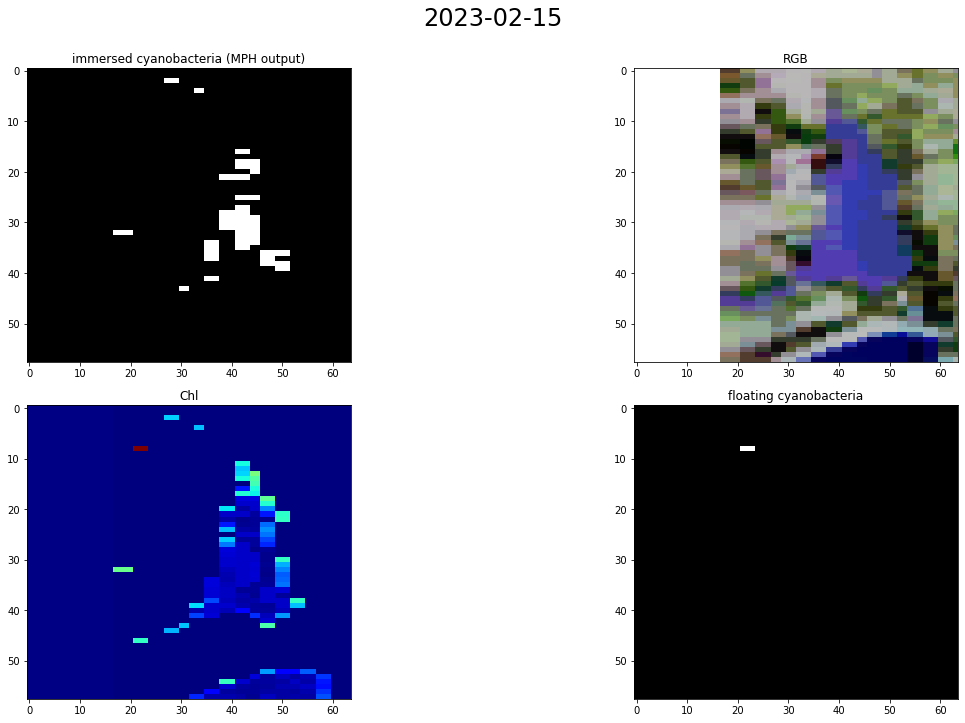

In [49]:
# unseen_data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True, 
#                                       start_date="2022-12-01", end_date="2022-12-20")

# sampling_points_coords = {"SAUCE NORTE": [-34.799398, -55.047355],
#                           "SAUCE SUR": [-34.843127, -55.064624],
#                           "OSE": [-34.829670, -55.048758]}

unseen_data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True, 
                                       dates_list=unseen_dates)
sampling_points_coords = {"SAUCE NORTE": [-34.799398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          }


save_directory = "/home/enzo/Cyano_Detection/data/final/validation"
unseen_data_preds = []
for olci_data in unseen_data_generator:
    olci_data.create_sparse_mask([c for c in sampling_points_coords.values()])
    print(olci_data.date)
    fig2 = plt.figure(figsize=(20,10))
    
    fig2.add_subplot(221).title.set_text("immersed cyanobacteria (MPH output)")
    plt.imshow(olci_data.mph.immersed_cyanobacteria, cmap="gray")
    
    fig2.add_subplot(222).title.set_text("RGB")
    #day.paint_coords(CONTROL_COORDS, [255, 119, 255])
    for location_name, location_coords in sampling_points_coords.items():
        print(location_name)
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        #get a 3x3 grid centered on the sampling location
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()

        model_input = np.array([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
        
        gaussianNB_output = gaussianNB_model.predict(model_input.reshape(1, -1))[0]
        svc_output = svc_model.predict(model_input.reshape(1, -1))[0]
        mph_output = olci_data.get_mph_bloom_in_locations([location_coords])
        mph_output = "Bloom" if mph_output == True else "No Bloom"
        print(f"SVC model output: {svc_output}")
        print(f"GaussianNB model output: {gaussianNB_output}")
        print(f"MPH output: {mph_output}")
        unseen_data_preds.append({"date": olci_data.date.date(),
                                "location": location_name,
                                "mph": mph_output,
                                "svc": svc_output,
                                "NB": gaussianNB_output})
        
    plt.imshow(olci_data.rgb)
    
    fig2.add_subplot(223).title.set_text("Chl")
    plt.imshow(olci_data.mph.chl, cmap='jet', interpolation='none',
              vmin=0, vmax=350)
    
    fig2.add_subplot(224).title.set_text("floating cyanobacteria")
    plt.imshow(olci_data.mph.floating_cyanobacteria, cmap="gray")
    
    fig2.suptitle(str(olci_data.date.date()), fontsize=24, y=1)
    fig2.tight_layout()
    
    plt.savefig(os.path.join(save_directory, str(olci_data.date.date())))
    print("--------------------")
unseen_data_preds_df = pd.DataFrame(unseen_data_preds)

In [50]:
unseen_data_preds_df

,date,location,mph,svc,NB
0,2022-11-16,SAUCE NORTE,No Bloom,No Bloom,No Bloom
1,2022-11-16,SAUCE SUR,No Bloom,No Bloom,No Bloom
2,2022-12-05,SAUCE NORTE,Bloom,No Bloom,No Bloom
3,2022-12-05,SAUCE SUR,Bloom,No Bloom,No Bloom
4,2022-12-09,SAUCE NORTE,Bloom,Bloom,Bloom
5,2022-12-09,SAUCE SUR,Bloom,Bloom,Bloom
6,2022-12-14,SAUCE NORTE,Bloom,Bloom,Bloom
7,2022-12-14,SAUCE SUR,Bloom,No Bloom,No Bloom
8,2022-12-30,SAUCE NORTE,No Bloom,No Bloom,Bloom
9,2022-12-30,SAUCE SUR,No Bloom,No Bloom,Bloom


In [51]:
unseen_data_xls_path = os.path.join(save_directory, "MUESTREOS 2022-2023.xls")
xls_sample_locations = ["ARROYO SAUCE", "MALLORQUINA", "SAUCE NORTE", "SAUCE SUR", "CISNES", "POTRERO"]
parsed_xls = parse_ficocianina_xls(unseen_data_xls_path, xls_sample_locations)

parsed_xls = parsed_xls[parsed_xls["location"].isin(["SAUCE NORTE", "SAUCE SUR"])]
parsed_xls = parsed_xls[parsed_xls["date"].isin(unseen_data_preds_df["date"].unique())]
parsed_xls = parsed_xls.reset_index()

labels = []
for i, row in parsed_xls.iterrows():
    if row["fico"] >= bloom_thresholds[row["location"]]:
        labels.append("Bloom")
    else:
        labels.append("No Bloom")
parsed_xls["label"] = labels

# select the rows by their indexes
row1 = parsed_xls.loc[12]
row2 = parsed_xls.loc[13]

# get the index of the second row
index = parsed_xls.index.get_loc(13)

# insert the selected rows after the original ones
parsed_xls = parsed_xls.loc[:index].append([row1, row2], ignore_index=True).append(parsed_xls.loc[index + 1:], ignore_index=True)
parsed_xls


          date      location    fico
0   2022-06-23  ARROYO SAUCE   740.0
1   2022-06-23   MALLORQUINA   737.5
2   2022-06-23   SAUCE NORTE  1002.5
3   2022-06-23     SAUCE SUR   809.0
4   2022-06-23        CISNES   780.0
..         ...           ...     ...
119 2023-02-25   MALLORQUINA  1812.0
120 2023-02-25   SAUCE NORTE  1412.5
121 2023-02-25     SAUCE SUR  2002.5
122 2023-02-25        CISNES  1669.0
123 2023-02-25       POTRERO  2353.5

[124 rows x 3 columns]
          date      location   chl
0   2022-06-23  ARROYO SAUCE  4.90
1   2022-06-23   MALLORQUINA  4.05
2   2022-06-23   SAUCE NORTE  3.35
3   2022-06-23     SAUCE SUR  4.95
4   2022-06-23        CISNES  4.00
..         ...           ...   ...
119 2023-02-25   MALLORQUINA  3.80
120 2023-02-25   SAUCE NORTE  3.40
121 2023-02-25     SAUCE SUR  4.70
122 2023-02-25        CISNES  3.60
123 2023-02-25       POTRERO  3.90

[124 rows x 3 columns]


,index,date,location,fico,chl,label
0,38,2022-11-16,SAUCE NORTE,746.0,3.10,No Bloom
1,39,2022-11-16,SAUCE SUR,1091.5,0.85,No Bloom
2,50,2022-12-05,SAUCE NORTE,13448.5,4.55,Bloom
3,51,2022-12-05,SAUCE SUR,2581.5,1.25,No Bloom
4,56,2022-12-09,SAUCE NORTE,9209.5,0.70,Bloom
5,57,2022-12-09,SAUCE SUR,12102.0,0.75,Bloom
6,62,2022-12-14,SAUCE NORTE,24380.0,1.85,Bloom
7,63,2022-12-14,SAUCE SUR,5066.0,0.55,No Bloom
8,74,2022-12-30,SAUCE NORTE,3991.0,8.35,No Bloom
9,75,2022-12-30,SAUCE SUR,5596.5,8.10,No Bloom


              precision    recall  f1-score   support

       Bloom       0.73      1.00      0.84         8
    No Bloom       1.00      0.70      0.82        10

    accuracy                           0.83        18
   macro avg       0.86      0.85      0.83        18
weighted avg       0.88      0.83      0.83        18



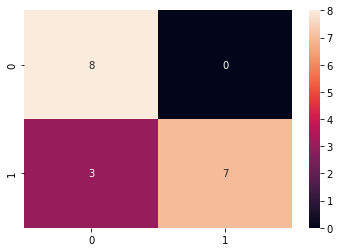

In [52]:
# extract the predictions from df1
y_pred = unseen_data_preds_df['mph']

# extract the ground truth from df2
y_true = parsed_xls['label']

# calculate the classification report
report = classification_report(y_true, y_pred)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
print(report)

              precision    recall  f1-score   support

       Bloom       1.00      0.62      0.77         8
    No Bloom       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18



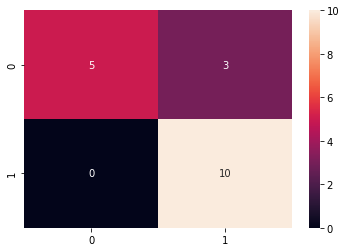

In [53]:
# extract the predictions from df1
y_pred = unseen_data_preds_df['svc']

# extract the ground truth from df2
y_true = parsed_xls['label']

# calculate the classification report
report = classification_report(y_true, y_pred)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
print(report)

              precision    recall  f1-score   support

       Bloom       0.75      0.75      0.75         8
    No Bloom       0.80      0.80      0.80        10

    accuracy                           0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18



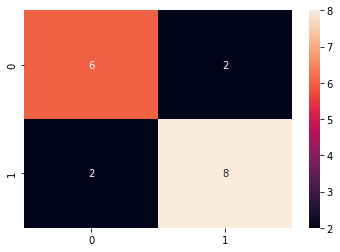

In [54]:
# extract the predictions from df1
y_pred = unseen_data_preds_df['NB']

# extract the ground truth from df2
y_true = parsed_xls['label']

# calculate the classification report
report = classification_report(y_true, y_pred)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
print(report)